In [17]:
import pandas as pd
import numpy as np

from scipy.stats import expon, norm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.model_selection import RandomizedSearchCV as RSCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV as HRSCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [6]:
# load data
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

x_train = np.asarray(x_train, dtype = np.float32)
x_test = np.asarray(x_test, dtype = np.float32)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1095, 89) (1095,) (365, 89) (365,)


## Grid Search

In [7]:
dtr = DecisionTreeRegressor()

# set searching hyperparameters
search_params = {
    'max_depth': np.arange(3, 11),
    'ccp_alpha': np.linspace(0, 2, 10)
}

# define Grid search algorithm
grid_search = GSCV(
    dtr, search_params, verbose = 2,
    scoring = 'neg_mean_absolute_error', 
    n_jobs = 4, cv = 5, refit = True
)

grid_search.fit(x_train, y_train)

print(f'Best score is {(-1) * grid_search.best_score_:.4f}')
print(f'Best params is {grid_search.best_params_}')

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best score is 24264.0194
Best params is {'ccp_alpha': 0.8888888888888888, 'max_depth': 7}


## Random Search

In [9]:
dtr = DecisionTreeRegressor()

# set searching hyperparameters
search_params = {
    'max_depth': np.arange(3, 11),
    'ccp_alpha': norm(loc = 1.5, scale = 0.5)
}

# define random search algorithm
random_search = RSCV(
    dtr, search_params, n_iter = 80, 
    scoring = 'neg_mean_absolute_error', 
    n_jobs = 4, refit = True, verbose = 2
)

random_search.fit(x_train, y_train)

print(f'Best score is {(-1) * random_search.best_score_:.4f}')
print(f'Best params is {random_search.best_params_}')

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best score is 24259.1229
Best params is {'ccp_alpha': 2.2934071147279997, 'max_depth': 8}


## Multi-fidelity searching

In [10]:
max_depth = np.arange(4, 11)
max_feature = np.arange(40, 89, 7)

param1_lst, param2_lst = max_depth, max_feature
data_split = 4
score_record = np.zeros((data_split, len(param1_lst), len(param2_lst)))

for n in range(data_split, 1, -1):
    _, x, _, y = train_test_split(x_train, y_train, test_size = (1 / n))
    for i, param1 in enumerate(param1_lst):
        for j, param2 in enumerate(param2_lst):
            model = RandomForestRegressor(max_depth = param1, max_features = param2, n_estimators = 10)
            model.fit(x, y)
            pred = model.predict(x_test)
            score = MAPE(y_test, pred)
            score_record[4 - n, i, j] = score

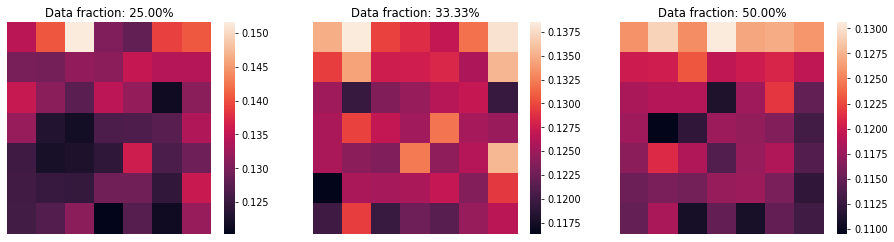

In [11]:
plt.figure(figsize = (16, 4), dpi = 70)

for i in range(3):
    plt.subplot(1, 3, i + 1)
    sns.heatmap(score_record[i])
    plt.title(f'Data fraction: {1 / (4 - i):.2%}')
    plt.axis('off')

plt.show()

## Successive Halving

In [18]:
RF = RandomForestRegressor()

# set searching hyperparameters
search_params = {
    'n_estimators': np.arange(20, 101),
    'max_depth': np.arange(7, 20),
    'ccp_alpha': np.abs(norm(loc = 1.5, scale = 0.5).rvs(size=20)),
    'criterion': ['mae', 'mse'],
    'min_samples_split': np.arange(2, 8),
    'min_impurity_decrease': np.abs(norm(loc = 1, scale = 0.5).rvs(size=30))
}

# set Successive Halving algorithm
SH_search = HRSCV(
    estimator = RF, param_distributions = search_params, n_candidates = 80, 
    factor = 2, resource = 'n_samples', max_resources='auto', min_resources='smallest', 
    aggressive_elimination=False, cv=3, scoring='neg_mean_absolute_error', refit=True,
    return_train_score=True, random_state=None, n_jobs=4, verbose=0
)

SH_search.fit(x_train, y_train)

print(f'Best score is {(-1) * SH_search.best_score_:.4f}')
print(f'Best params is {SH_search.best_params_}')

Best score is 19122.0060
Best params is {'n_estimators': 71, 'min_samples_split': 2, 'min_impurity_decrease': 1.0871493201157156, 'max_depth': 12, 'criterion': 'mae', 'ccp_alpha': 1.0986081239541015}


In [19]:
def regression_report(y_true, pred, verbose = True):
    mse = MSE(y_true, pred)
    mae = MAE(y_true, pred)
    rmse = np.sqrt(mse)
    mape = MAPE(y_true, pred)
    if verbose:
        print(f'mse = {mse:.4f}')
        print(f'mae = {mae:.4f}')
        print(f'rmse = {rmse:.4f}')
        print(f'mape = {mape:.4f}')

    # return mse, mae, rmse, mape

In [20]:
best_params = SH_search.best_params_
best_params['n_jobs'] = 4

RF = RandomForestRegressor(**best_params)
RF.fit(x_train, y_train)

pred = RF.predict(x_test)
regression_report(y_test, pred, verbose = 1)

mse = 983929028.3011
mae = 17784.9088
rmse = 31367.6430
mape = 0.1019


## Feature Importance demo (easy version)

In [22]:
df = pd.read_csv('df_fe.csv').drop(columns = ['SalePrice'])
importance_idx = np.argsort(RF.feature_importances_)[::-1]
importance = RF.feature_importances_[importance_idx]
impo_label = df.columns[importance_idx]

FileNotFoundError: [Errno 2] No such file or directory: 'df_fe.csv'

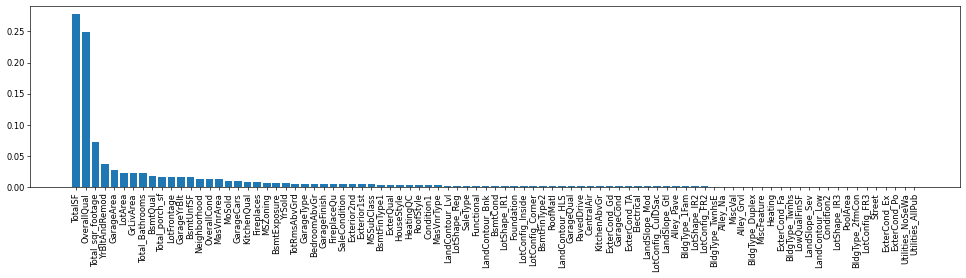

In [22]:
plt.figure(figsize = (20, 4), dpi = 60)
plt.bar(impo_label, importance)
plt.xticks(rotation='vertical')
plt.show()

In [29]:
# 篩選特徵
filter = 25
x_train_fe = x_train[:, importance_idx[:filter]]
x_test_fe = x_test[:, importance_idx[:filter]]

SH_search.fit(x_train_fe, y_train)
print(f'Best score is {(-1) * SH_search.best_score_:.4f}')
print(f'Best params is {SH_search.best_params_}')

Best score is 18683.9334
Best params is {'n_estimators': 87, 'min_samples_split': 2, 'min_impurity_decrease': 1.351150397375558, 'max_depth': 16, 'criterion': 'mae', 'ccp_alpha': 1.5150667242965103}


In [34]:
best_params = SH_search.best_params_
best_params['n_jobs'] = 4

RF = RandomForestRegressor(**best_params)
RF.fit(x_train_fe, y_train)

pred = RF.predict(x_test_fe)
print(f'只用 {x_train.shape[1]} 特徵中的其中 {x_train_fe.shape[1]} 個即可達到相近的誤差')
regression_report(y_test, pred, 1)

只用 89 特徵中的其中 25 個即可達到相近的誤差
mse = 1094718135.5517
mae = 18277.3033
rmse = 33086.5250
mape = 0.1036
